## Building a regression model

In [148]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import date
import matplotlib.ticker as ticker

We'll be taking a look at death rate over time. We'll compile all the days of case information (similar to 4.18_states.csv, but for all dates up until today) to assemble our training matrix X.

In [149]:
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv',
           error_bad_lines=False)
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
                   error_bad_lines=False)
#cases['FIPS'] = cases['FIPS'].astype('int')
day_cases = get_day_cases()
counties = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv',
                      error_bad_lines=False)
county_cases = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_level/processed/nytimes_infections/nytimes_infections.csv',
                          error_bad_lines=False)

death_keep = [col+'_deaths' if (col in cases.columns and col != 'FIPS') else col for col in deaths.columns]
cases_keep = [col+'_cases' for col in cases.columns[12:]]
cases_and_deaths = cases.merge(deaths, on='FIPS', suffixes=('_cases', '_deaths'))[death_keep+cases_keep]
renamer = lambda name: name if (type(name) != str or '/' in name or '_deaths' not in name) else name[:-7]
cases_and_deaths = cases_and_deaths.rename(columns=renamer)
cases_and_deaths.head()

valid_territories = cases_and_deaths[(cases_and_deaths['Lat'] > 0) & ~np.isnan(cases_and_deaths['FIPS'])]
valid_territories.loc[:, 'FIPS'] = valid_territories['FIPS'].astype('int')
valid_counties = counties[~counties['countyFIPS'].isin(['City1', 'City2'])]
valid_counties.loc[:, 'countyFIPS'] = valid_counties['countyFIPS'].astype('int')

county_all = valid_counties.merge(valid_territories, left_on='countyFIPS', right_on='FIPS')
county_all = county_all.drop(columns=['Lat', 'Long_', 'Province_State', 'Country_Region', 'FIPS'])

/Users/andyflury/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [150]:
get_trait_ts = lambda terr, trait: [day_cases[day][trait][terr] for day in range(len(day_cases))]

In [151]:
mort_rates = np.zeros((50, len(day_cases)))
for terr in range(50):
    mort_rates[terr, :] = get_trait_ts(terr, 'Mortality_Rate')
start, end = datetime.datetime(2020, 4, 12), datetime.datetime(2020, 5, 12)
mort_matrix = pd.DataFrame(mort_rates, index=day_cases[0]['Province_State'], columns = pd.date_range(start, end))


Now that we have our csv assembled, we can begin creating our model.

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn import metrics


def cross_validate_acc(model, X, y):
    model = clone(model, safe=False)
    five_fold = KFold(n_splits=5)
    acc_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y[tr_ind])
        acc_values.append(model.score(X.iloc[va_ind,:], y[va_ind]))
    return np.mean(acc_values)

def cross_validate_rmse(model, X, y):
    model = clone(model, safe=False)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

We will break down the immense task of predicting COVID-19 incidence by examining states at a time. The funcion below will assemble our training matrix with the proper state and features. These features were selected after examining cross validation RMSE and are the most descriptive we could find within our own datasets.

In [155]:
def get_single_state(state='California'):
    features_of_interest = ['Confirmed', 'Deaths', 'Active', 'Incident_Rate', 'Mortality_Rate']
    state_df = pd.DataFrame({'day': np.zeros(5)})
    for df in day_cases:
        row = df.loc[df['Province_State'] == state]
        date = pd.to_datetime(row['Last_Update'].values[0])
        state_df[date] = np.array(row[features_of_interest].values[0])
    state_df = state_df.drop('day', axis =1)
    state_df.index = features_of_interest
    return state_df.T

def get_country():
    nation_df = pd.DataFrame()
    for state in day_cases[0]['Province_State']:
        df = get_single_state(state)
        nation_df = nation_df.append(df)
    return nation_df

def create_model(state='California', nation=False, future=13, past=13):
    model = LinearRegression()
    matrix = get_single_state(state)
    X_train = matrix.iloc[-2*past:-1*past, :]
    y_train = matrix['Mortality_Rate'][-1*past:]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    print('Training Error:', rmse(y_train, y_hat))
    print('Cross Validation Error', cross_validate_rmse(model, X_train, y_train))
    return model


model13 = create_model()
def plot_predictions(model, matrix, state='State Name Here', forecast=20):
    guess = model.predict(matrix.iloc[-1 * forecast:,:])
    x = range(forecast)
    
    ax = sns.scatterplot(x =x, y=guess)
    ax.set(xlabel='Days Past '+str(date.today()), ylabel='Mortality Rate')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set(title='Mortality Rate over Time, ' + state)
    plt.show()



Training Error: 0.020658407407562
Cross Validation Error 0.03369581902636094


The training error and cross validation error are fairly good, considering the magnitude of our data set (on the order of 10^1). The function plot_predictions() will take a model, a state, and a forecast (number of days) in order to predict the mortality rate in the future.

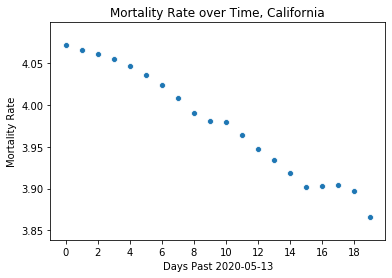

In [159]:
plot_predictions(model13, get_single_state('California'), state='California')

#### Note that our model suffers greatly when the change over the given number of days is extreme or quite drastic. NY is a good example of our momdel failing.